In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from tqdm import tqdm_notebook as tqdm
import arepo
from scipy.ndimage import gaussian_filter
from scipy.stats import norm, binned_statistic
import h5py as h5

In [2]:
def read_freq(name, lvl, freq_path = '/n/home01/abeane/starbar/plots/orbit_int/data/'):
    # Pull in the relevant files.
    prefix = freq_path + name + '-' + lvl + '/freqs_' + name + '-' + lvl
    files = glob.glob(prefix + '.*.npy')
    
    # Sort files by integer index.
    files.sort(key=lambda x: int(x.split(name+'-'+lvl)[-1].split('.')[1]))
    
    # Now read in files
    out = np.concatenate([np.load(fname) for fname in tqdm(files)])
    
    return out

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [4]:
freqs_N = read_freq('Nbody', 'lvl3')

A Jupyter Widget

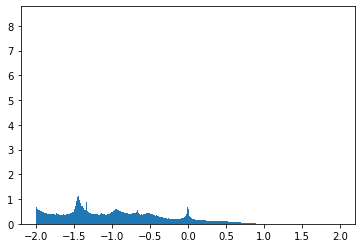

In [7]:
ps = 36.286223853227966
n, bins, _ = plt.hist((freqs_N[:,0]-ps)/freqs_N[:,2], bins=np.linspace(-2, 2, 1000), density=True)
dfreq = 1.0

# plt.axvline(freq, c='r')
# plt.axvline(freq + dfreq/2.0, c='r', ls='dashed')
# plt.axvline(freq - dfreq/2.0, c='r', ls='dashed')

# plt.yscale('log')
plt.show()

In [59]:
x = (bins[:-1] + bins[1:])/2.0
print(x[np.argmax(n)])

36.27377377377377


In [19]:
freqs_S = read_freq('phantom-vacuum-Sg20-Rc3.5', 'lvl3')

A Jupyter Widget

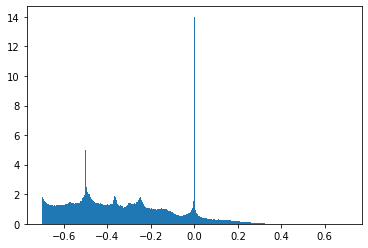

In [125]:
ps = 40.444902670072224
n, bins, _ = plt.hist((freqs_S[:,0]-ps)/freqs_S[:,1], bins=np.linspace(-0.7, 0.7, 1000), density=True)
freq = 40.444902670072224
dfreq = 0.8

# plt.axvline(freq, c='r')
# plt.axvline(freq + dfreq/2.0, c='r', ls='dashed')
# plt.axvline(freq - dfreq/2.0, c='r', ls='dashed')

# plt.yscale('log')
plt.show()

In [9]:
sn_N = read_snap(500, 0, fields=None, parttype=None)
sn_S = read_snap(300, 1, fields=None, parttype=None)

sn_Nl = read_snap(500+200, 0, fields=None, parttype=1)
sn_S1 = read_snap(300+200, 1, fields=None, parttype=1)

In [10]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

def get_pos_vel(sn, center=np.array([0., 0., 0.]), bangle=0.):
    pos = sn.part1.pos.value - center
    vel = sn.part1.vel.value
    
    key = np.argsort(sn.part1.id)
    
    pos = rotate_pos(pos, -bangle)
    vel = rotate_pos(vel, -bangle)
    
    return pos[key], vel[key]
    

def get_E_Lz(sn, center=np.array([0., 0., 0.])):
    pos = sn.part1.pos.value - center
    vel = sn.part1.vel.value
    pot = sn.part1.pot.value
    
    E = 0.5 * np.linalg.norm(vel, axis=1)**2. + pot
    Lz = np.cross(pos, vel)[:,2]
    
    key = np.argsort(sn.part1.id)
    
    return E[key], Lz[key]
    

In [11]:
E_N, Lz_N = get_E_Lz(sn_N)
E_S, Lz_S = get_E_Lz(sn_S, center=np.array([200., 200., 200.]))

E_Nl, Lz_Nl = get_E_Lz(sn_Nl)
E_Sl, Lz_Sl = get_E_Lz(sn_S1, center=np.array([200., 200., 200.]))

dLz_N = Lz_Nl - Lz_N
dLz_S = Lz_Sl - Lz_S

In [13]:
ps_N = 36.286223853227966
ps_S = 40.444902670072224

at_CR_N = np.abs(freqs_N[:,0] - ps_N) < 0.1
# at_CR_S = np.abs(freqs_S[:,0] - ps_S) < 0.1
at_OLR_N = np.abs(freqs_N[:,0] + 0.5 * freqs_N[:,1] - ps_N) < 0.1
# at_OLR_S = np.abs(freqs_S[:,0] + 0.5 * freqs_S[:,1] - ps_S) < 0.1

near_CR_N = np.logical_and(np.logical_not(at_CR_N), np.abs(freqs_N[:,0]-ps_N) < 0.2)
# near_CR_S = np.logical_and(np.logical_not(at_CR_S), np.abs(freqs_S[:,0]-ps_S) < 0.2)

Nbody mean= 800.7054336728169  median= 804.8432465578433


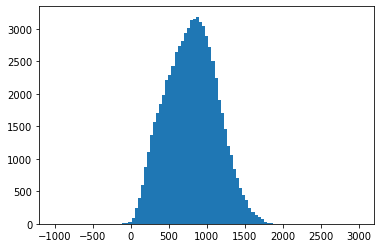

In [18]:
plt.hist(Lz_N[at_CR_N], bins=np.linspace(-1000, 3000, 100))
# plt.hist(Lz_S[at_CR_S], bins=np.linspace(-1000, 3000, 100))

print('Nbody mean=', np.mean(Lz_N[at_CR_N]), ' median=', np.median(Lz_N[at_CR_N]))
# print('SMUGGLE mean=', np.mean(Lz_S[at_CR_S]), ' median=', np.median(Lz_S[at_CR_S]))

plt.show()

Nbody mean= 734.062671413439  median= 717.6103503351621
SMUGGLE mean= 702.5379846354114  median= 692.59638403994


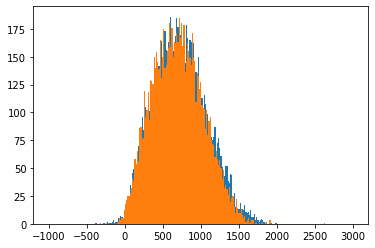

In [280]:
plt.hist(Lz_N[near_CR_N], bins=np.linspace(-1000, 3000, 256))
plt.hist(Lz_S[near_CR_S], bins=np.linspace(-1000, 3000, 256))

print('Nbody mean=', np.mean(Lz_N[near_CR_N]), ' median=', np.median(Lz_N[near_CR_N]))
print('SMUGGLE mean=', np.mean(Lz_S[near_CR_S]), ' median=', np.median(Lz_S[near_CR_S]))

plt.show()

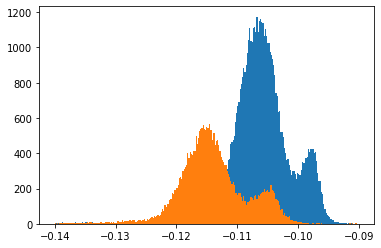

In [266]:
plt.hist(E_N[at_OLR_N]/1E6, bins=np.linspace(-0.14, -0.09, 256 ))
plt.hist(E_S[at_OLR_S]/1E6, bins=np.linspace(-0.14, -0.09, 256 ))
plt.show()

Nbody mean= -0.14068321163215597  median= -0.13929284844167986
SMUGGLE mean= -0.153106375  median= -0.1517455625


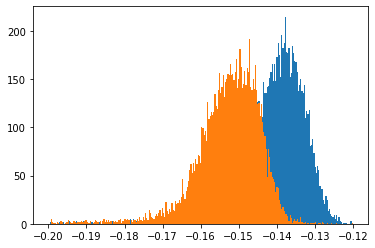

In [286]:
plt.hist(E_N[near_CR_N]/1E6, bins=np.linspace(-0.2, -0.12, 256 ))
plt.hist(E_S[near_CR_S]/1E6, bins=np.linspace(-0.2, -0.12, 256 ))

print('Nbody mean=', np.mean(E_N[near_CR_N]/1E6), ' median=', np.median(E_N[near_CR_N])/1E6)
print('SMUGGLE mean=', np.mean(E_S[near_CR_S])/1E6, ' median=', np.median(E_S[near_CR_S])/1E6)


plt.show()

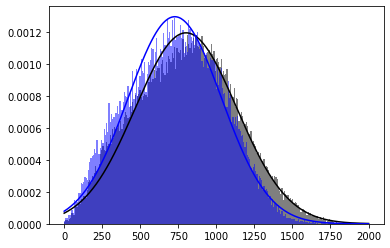

In [205]:
bins = np.linspace(0, 2000, 256)


mu_N, std_N = norm.fit(Lz_N[at_CR_N])
plt.hist(Lz_N[at_CR_N], bins=bins, density=True, color='k', alpha=0.5)
p = norm.pdf(bins, mu_N, std_N)
plt.plot(bins, p, c='k')

mu_S, std_S = norm.fit(Lz_S[at_CR_S])
plt.hist(Lz_S[at_CR_S], bins=bins, density=True, color='b', alpha=0.5)
p = norm.pdf(bins, mu_S, std_S)
plt.plot(bins, p, c='b')

# plt.hist(E_S[at_CR_S]/1E6, bins=np.linspace(-0.175, -0.125, 1000 ))
plt.show()

In [135]:
pos_N, vel_N = get_pos_vel(sn_N, bangle=1.2093156304455093)
pos_S, vel_S = get_pos_vel(sn_S, bangle=3.674321517797914, center=np.array([200., 200., 200.]))

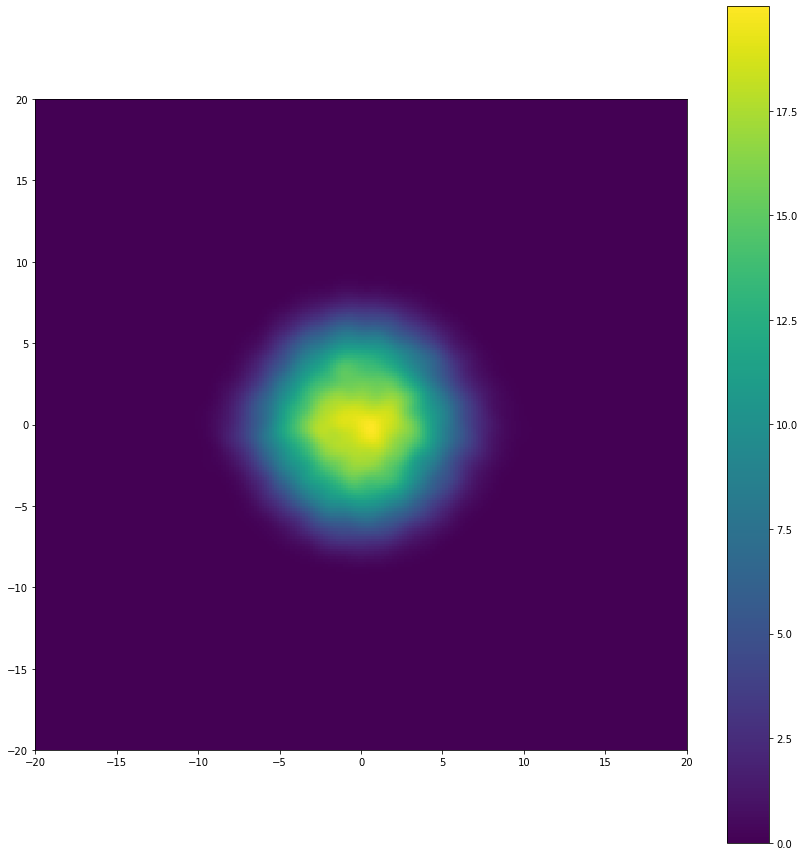

In [140]:
nres = 256

L = 20
range_xy = [[-L, L], [-L, L]]

x = pos_N[:,0][at_CR_N]
y = pos_N[:,2][at_CR_N]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
heatmap_xy = gaussian_filter(heatmap_xy, 3)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


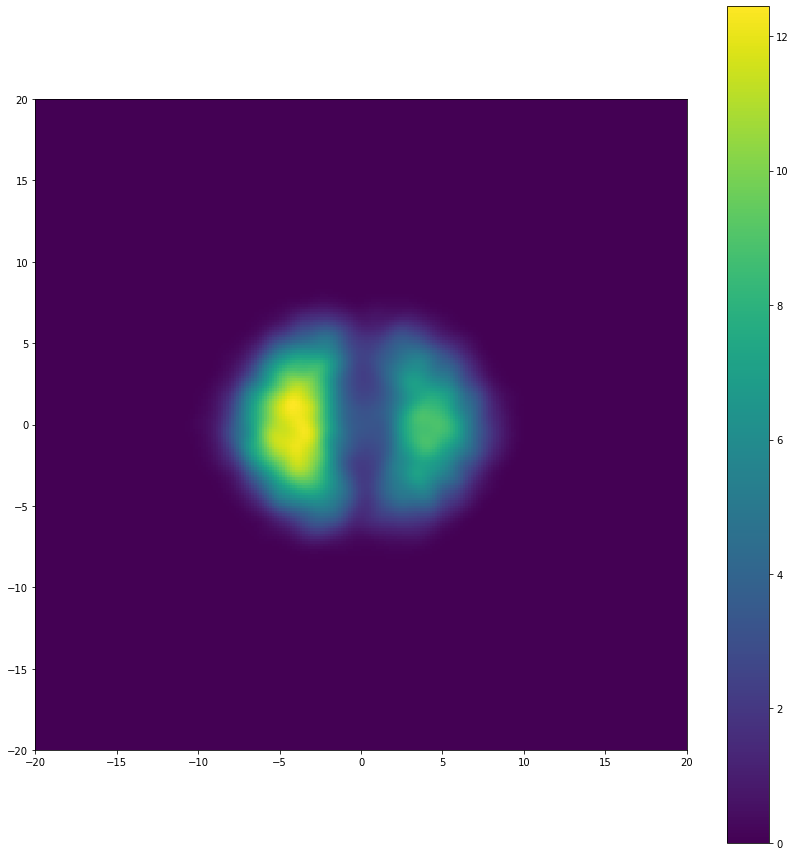

In [143]:
nres = 256

L = 20
range_xy = [[-L, L], [-L, L]]

x = pos_S[:,1][at_CR_S]
y = pos_S[:,2][at_CR_S]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
heatmap_xy = gaussian_filter(heatmap_xy, 3)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


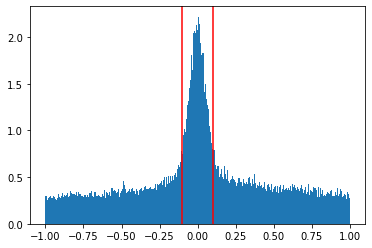

In [108]:
ps = 36.286223853227966
n, bins, _ = plt.hist((freqs_N[:,0]+0.5*freqs_N[:,1]-ps), bins=np.linspace(-1, 1, 1000), density=True)
dfreq = 1.0

plt.axvline(0.1, c='r')
plt.axvline(-0.1, c='r')
# plt.axvline(freq + dfreq/2.0, c='r', ls='dashed')
# plt.axvline(freq - dfreq/2.0, c='r', ls='dashed')

# plt.yscale('log')
plt.show()

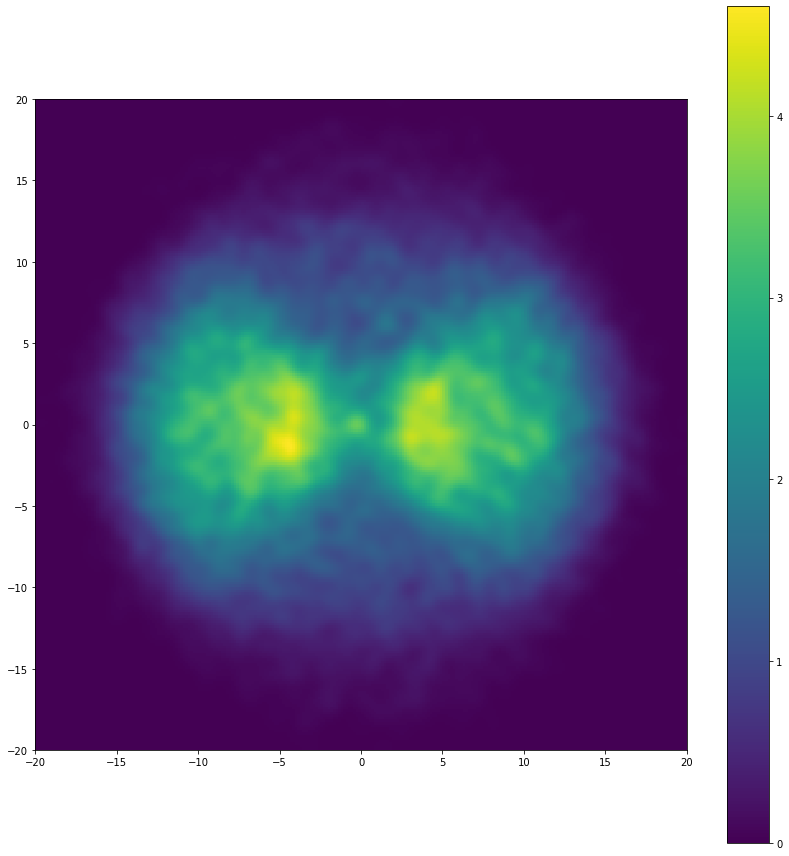

In [142]:
nres = 256

L = 20
range_xy = [[-L, L], [-L, L]]

x = pos_N[:,1][at_OLR_N]
y = pos_N[:,2][at_OLR_N]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

heatmap_xy = gaussian_filter(heatmap_xy, 3)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


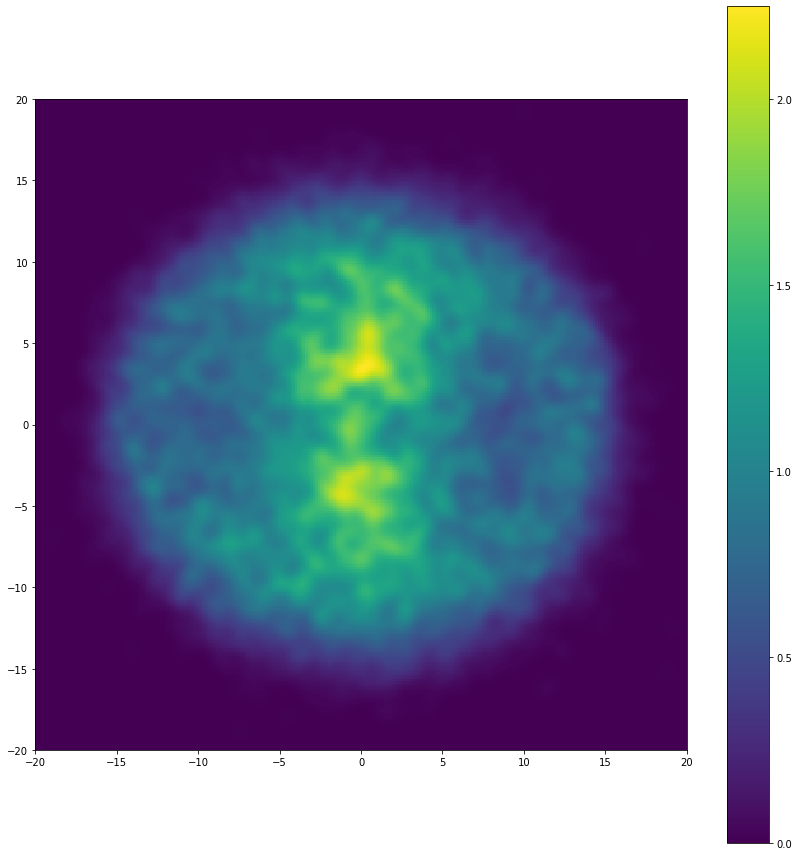

In [138]:
nres = 256

L = 20
range_xy = [[-L, L], [-L, L]]

x = pos_S[:,0][at_OLR_S]
y = pos_S[:,1][at_OLR_S]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

heatmap_xy = gaussian_filter(heatmap_xy, 3)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


(256, 256)
(2, 256, 256)


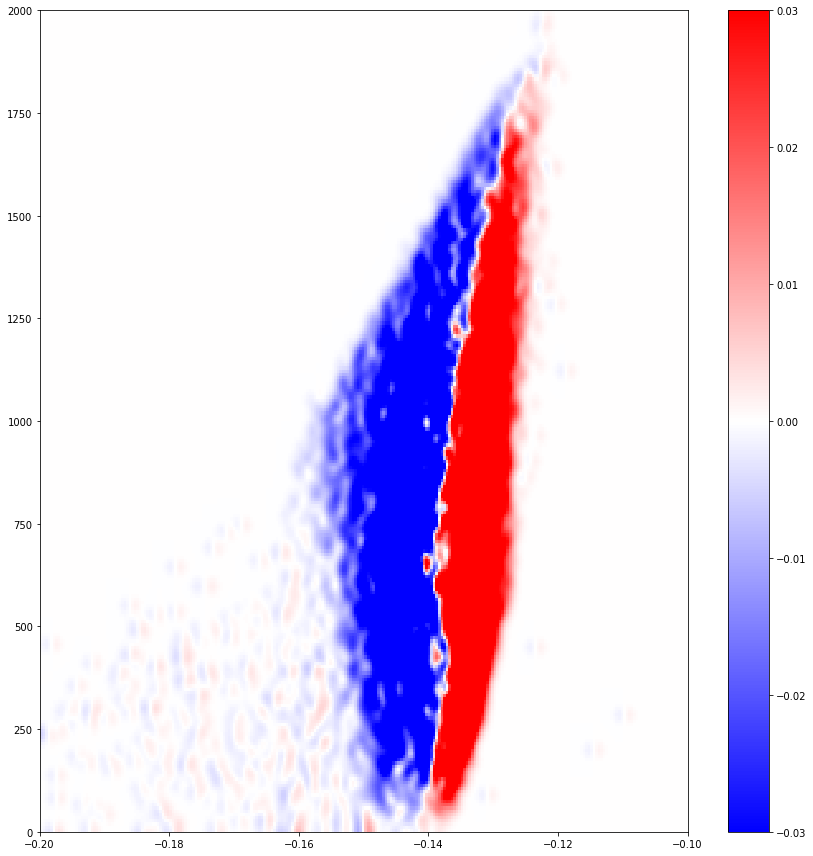

In [253]:
nres = 256

L = 20
range_xy = [[-0.2, -0.1], [0, 2000]]

x = E_N[at_CR_N]/1E6
y = Lz_N[at_CR_N]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

dx = (range_xy[0][1]-range_xy[1][1])/(nres-1)
dy = (range_xy[1][1]-range_xy[1][0])/(nres-1)

print(heatmap_xy.shape)

heatmap_xy = np.gradient(heatmap_xy, dx, dy)
print(np.shape(heatmap_xy))

for i in range(2):
    heatmap_xy[i] = gaussian_filter(heatmap_xy[i], 2)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy[0].T, extent=extent, origin='lower', vmin=-0.03, vmax=0.03, cmap='bwr')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('auto')
fig.colorbar(im)

fig.tight_layout()

plt.show()


(256, 256)
(2, 256, 256)


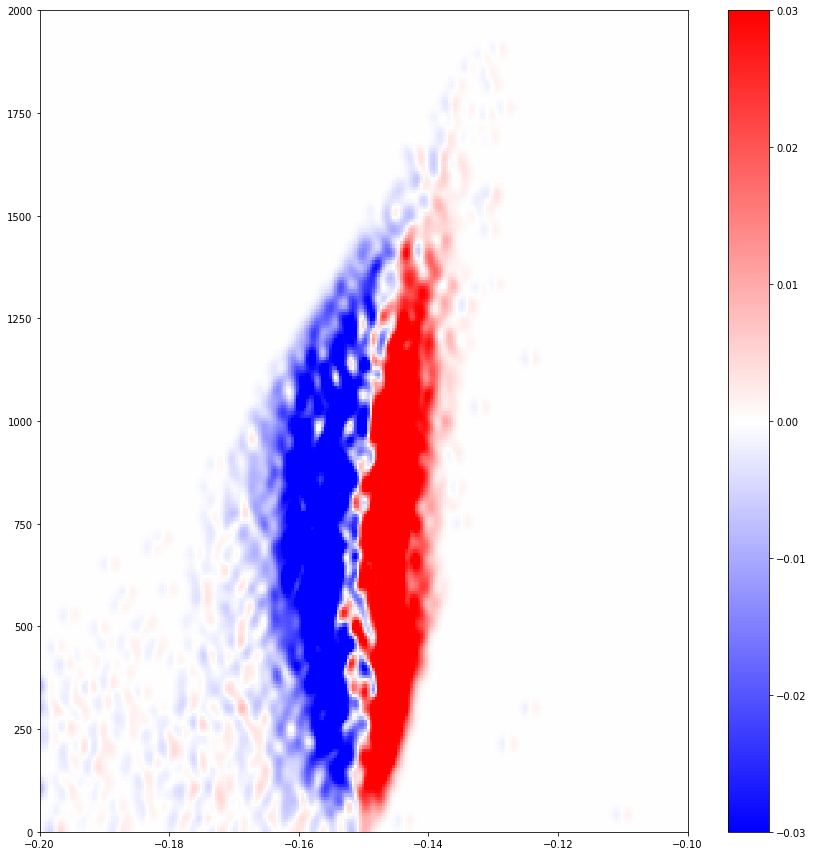

In [252]:
nres = 256

L = 20
range_xy = [[-0.2, -0.1], [0, 2000]]

x = E_S[at_CR_S]/1E6
y = Lz_S[at_CR_S]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)

dx = (range_xy[0][1]-range_xy[1][1])/(nres-1)
dy = (range_xy[1][1]-range_xy[1][0])/(nres-1)

print(heatmap_xy.shape)

heatmap_xy = np.gradient(heatmap_xy, dx, dy)
print(np.shape(heatmap_xy))

for i in range(2):
    heatmap_xy[i] = gaussian_filter(heatmap_xy[i], 2)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy[0].T, extent=extent, origin='lower', vmin=-0.03, vmax=0.03, cmap='bwr')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('auto')
fig.colorbar(im)

fig.tight_layout()

plt.show()


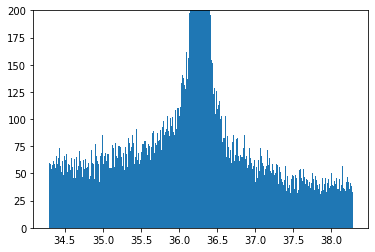

In [212]:
plt.hist(freqs_N[:,0], bins=np.linspace(ps_N-2, ps_N+2, 1024))
plt.ylim(0, 200)

plt.show()

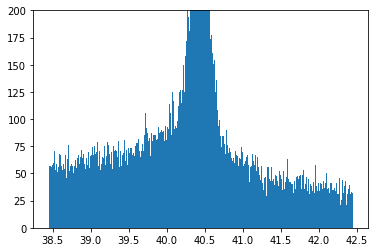

In [211]:
plt.hist(freqs_S[:,0], bins=np.linspace(ps_S-2, ps_S+2, 1024))
plt.ylim(0, 200)

plt.show()

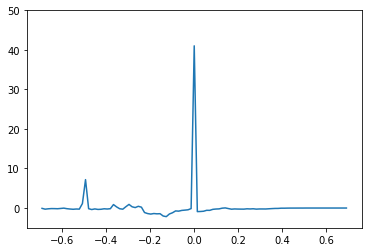

In [245]:
ps = 36.286223853227966
stat, bins, _ = binned_statistic((freqs_N[:,0]-ps)/freqs_N[:,1], sn_N.MassTable[1]*dLz_N, bins=np.linspace(-0.7, 0.7, 100), statistic='sum')
# n, bins, _ = plt.hist((freqs_N[:,0]-ps)/freqs_N[:,1], bins=np.linspace(-0.7, 0.7, 1000))#, weights=sn_N.MassTable[1]*dLz_N)
dfreq = 1.0

# plt.axvline(freq, c='r')
# plt.axvline(freq + dfreq/2.0, c='r', ls='dashed')
# plt.axvline(freq - dfreq/2.0, c='r', ls='dashed')

x = (bins[0:-1] + bins[1:])/2.

plt.plot(x, stat)

# plt.yscale('log')
plt.ylim(-5, 50)
plt.show()

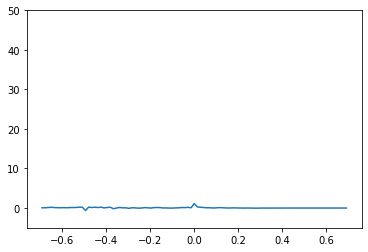

In [244]:
stat, bins, _ = binned_statistic((freqs_S[:,0]-ps_S)/freqs_S[:,1], sn_S.MassTable[1]*dLz_S, bins=np.linspace(-0.7, 0.7, 100), statistic='sum')
# n, bins, _ = plt.hist((freqs_N[:,0]-ps)/freqs_N[:,1], bins=np.linspace(-0.7, 0.7, 1000))#, weights=sn_N.MassTable[1]*dLz_N)
dfreq = 1.0

# plt.axvline(freq, c='r')
# plt.axvline(freq + dfreq/2.0, c='r', ls='dashed')
# plt.axvline(freq - dfreq/2.0, c='r', ls='dashed')

x = (bins[0:-1] + bins[1:])/2.

plt.plot(x, stat)
plt.ylim(-5, 50)

# plt.yscale('log')
# plt.ylim(-50, 50)
plt.show()

In [238]:
dLz_S

array([0., 0., 0., ..., 0., 0., 0.])

In [256]:
np.sum(sn_N.MassTable[1]*dLz_N[at_CR_N])

39.80580817848807

In [258]:
ps_Nl = 30.212610850599958

print(ps_N/ps_Nl)
print(np.sum(Lz_Nl[at_CR_N])/np.sum(Lz_N[at_CR_N]))


1.2010290680491587
1.1897379294050348


In [259]:
ps_Nl = 30.212610850599958

print(ps_N/ps_Nl)
print(np.sum(Lz_Nl[at_OLR_N])/np.sum(Lz_N[at_OLR_N]))

1.2010290680491587
1.0317541434026158


In [271]:
pos_Nl, vel_Nl = get_pos_vel(sn_Nl, bangle=2.731326610363368)


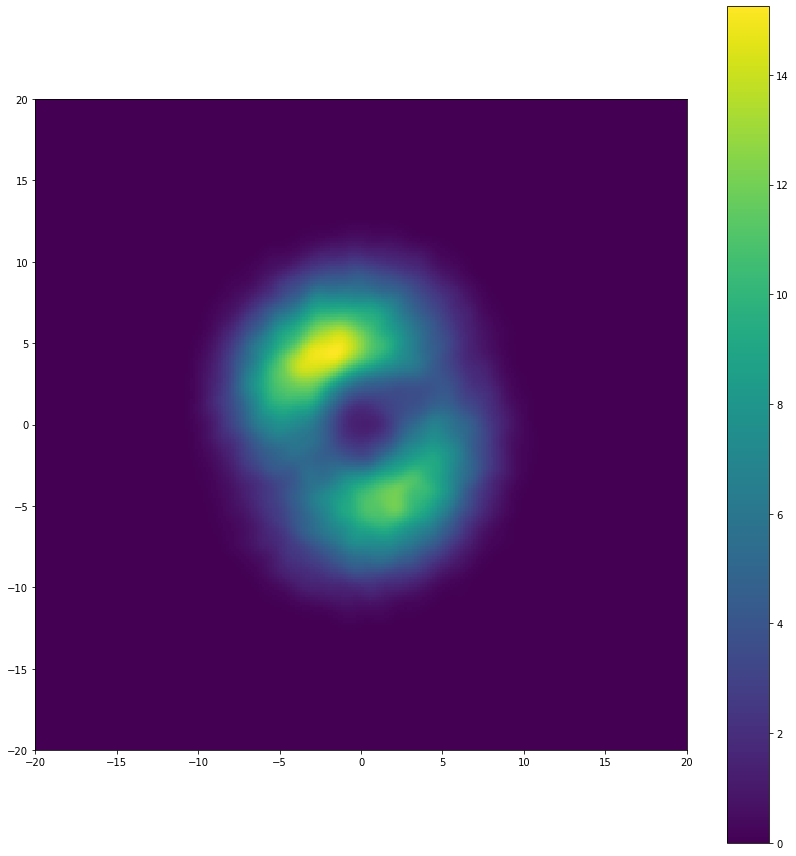

In [274]:
nres = 256

L = 20
range_xy = [[-L, L], [-L, L]]

x = pos_Nl[:,0][at_CR_N]
y = pos_Nl[:,1][at_CR_N]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
heatmap_xy = gaussian_filter(heatmap_xy, 3)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = ax.imshow(heatmap_xy.T, extent=extent, origin='lower')#, vmin=-0.2, vmax=0.2)#, vmin=-50000, vmax=50000)
ax.set_aspect('equal')
fig.colorbar(im)

fig.tight_layout()

plt.show()


In [ ]:
import glob
torque_path = '/n/home01/abeane/starbar/plots/torques-rot/data/'
name = 'phantom-vacuum-Sg20-Rc3.5'
lvl = 'lvl3-rot40'

nsnap = len(glob.glob(torque_path+'torques_'+name+'-'+lvl+'/*.hdf5'))

total_torque = {}
total_torque['bar'] = []
total_torque['gas'] = []
total_torque['halo'] = []
total_torque['not_bar'] = []
time = []

for i in tqdm(range(nsnap)):
    fname = torque_path + 'torques_' + name + '-' + lvl + '/torques_' + name +'-' + lvl + '.' + str(i) + '.hdf5'
    t = h5.File(fname)
    
    time.append(t['parameters'].attrs['Time'])
    total_torque['bar'].append(t['total_torques'].attrs['bar'])
    total_torque['gas'].append(t['total_torques'].attrs['gas'])
    total_torque['halo'].append(t['total_torques'].attrs['halo'])
    total_torque['not_bar'].append(t['total_torques'].attrs['not_bar'])
    
for k in total_torque.keys():
    total_torque[k] = np.array(total_torque[k])
time = np.array(time)

A Jupyter Widget

In [ ]:
plt.plot(time, )